# DEM management

DEM are used in two ways in **EOReader**:
- for computing DEM bands (`DEM`, `SLOPE`, `HILLSHADE`)
- for orthorectification (SAR, with SNAP or VHR data)

There are several things you need to know to handle DEMs properly.

In [1]:
# Imports
import os
import tempenv

import matplotlib.pyplot as plt


from eoreader.reader import Reader
from eoreader.bands import DEM, SLOPE, HILLSHADE, VV, RED
from eoreader.env_vars import DEM_PATH, DEM_VCRS, SNAP_DEM_NAME
from eoreader.keywords import DEM_KW, SLOPE_KW, HILLSHADE_KW
from eoreader.products import SnapDems

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

In [3]:
# Open the product
path = os.path.join("/home", "prods", "S2", "PB 02.07+", "S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749.SAFE")
prod = Reader().open(path)

In [4]:
# DEM paths
dem_folder = os.path.join("/home", "ds2_db2", "BASES_DE_DONNEES", "GLOBAL")
dtm = os.path.join(dem_folder, "MERIT_Hydrologically_Adjusted_Elevations", "MERIT_DEM.vrt")
dem = os.path.join(dem_folder, "COPDEM_30m", "COPDEM_30m.vrt")
dem_tif = os.path.join(dem_folder, "EUDEM_v2", "eudem_wgs84.tif")

___
## DEM bands
DEM bands are computed using the DEM stored in the `EOREADER_DEM_PATH` environment variable.  
Without anything specified, DEM bands cannot be computed and an error will be thrown.


<div class="alert alert-warning">
  
<strong>Note:</strong> SAR products cannot load a <code>HILLSHADE</code> band !
    
</div>


In [5]:
# Error when computing the DEM band: Iy hasn't been specified it
try:
    prod.load(DEM)[DEM]
except ValueError as msg:
   logger.error(msg)     

2023-05-31 11:46:35,471 - [ERROR] - DEM path not set, unable to compute DEM bands! Please set the environment variable EOREADER_DEM_PATH or a DEM keyword.


In [6]:
# This works now
with tempenv.TemporaryEnvironment({DEM_PATH: dem}):
    prod.load(DEM)[DEM]

2023-05-31 11:46:35,485 - [DEBUG] - Loading DEM bands ['DEM']
2023-05-31 11:46:35,486 - [DEBUG] - Warping DEM for 20200114T065229_S2_T40REQ_L2A_094749
2023-05-31 11:46:35,487 - [DEBUG] - Using DEM: /home/data/DS2/BASES_DE_DONNEES/GLOBAL/COPDEM_30m/COPDEM_30m.vrt


However, in some cases, you may want to specify a specific DEM to load a band from it.

The most common use of this is:
- I want to compute the hillshade from a DEM
- I want to compute the slope of a DTM as I don't want the slopes of buildings or trees !
- I want those two bands coregistered by default

When specifying a DEM in the `load` or `stack` function, you don't need to set the `EOREADER_DEM_PATH` environment variable

In [7]:
dem_bands = prod.load(
    [DEM, SLOPE, HILLSHADE], 
    **{
        DEM_KW: dem,
        SLOPE_KW: dtm, # We want a DTM here
        HILLSHADE_KW: dem,        
    }
)

2023-05-31 11:49:08,486 - [DEBUG] - Loading DEM bands ['DEM', 'SLOPE', 'HILLSHADE']
2023-05-31 11:49:08,489 - [DEBUG] - Already existing DEM for 20200114T065229_S2_T40REQ_L2A_094749. Skipping process.
2023-05-31 11:49:10,335 - [DEBUG] - Warping DEM for 20200114T065229_S2_T40REQ_L2A_094749
2023-05-31 11:49:10,338 - [DEBUG] - Using DEM: /home/data/DS2/BASES_DE_DONNEES/GLOBAL/MERIT_Hydrologically_Adjusted_Elevations/MERIT_DEM.vrt
2023-05-31 11:49:10,599 - [DEBUG] - Computing slope for 20200114T065229_S2_T40REQ_L2A_094749
2023-05-31 11:56:15,503 - [DEBUG] - Already existing DEM for 20200114T065229_S2_T40REQ_L2A_094749. Skipping process.
2023-05-31 11:56:15,513 - [DEBUG] - Computing hillshade DEM for S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749


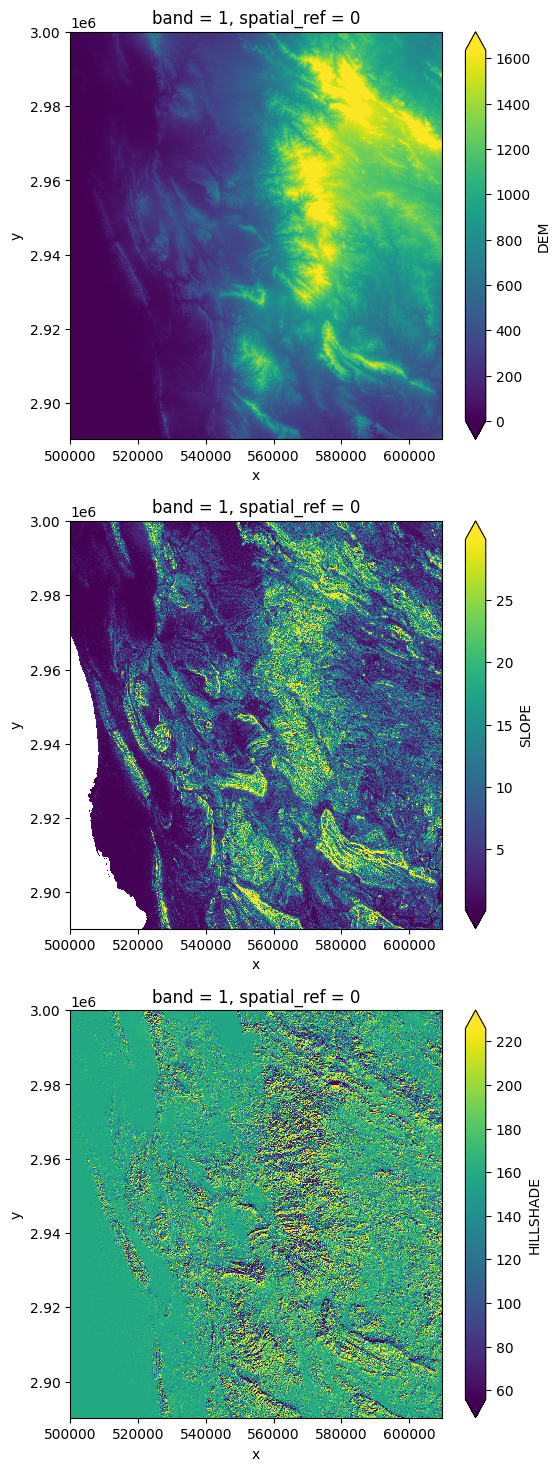

In [8]:
# Plot DEM bands
ncols = len(dem_bands)
plt.figure(figsize=(6, 6 * ncols))
i = 0
for key in dem_bands.keys():
    axes = plt.subplot(3, 1, i+1)
    dem_bands[key][0, ::10, ::10].plot.imshow(robust=True)
    i += 1

____
## Orthorectification
### SAR orthorectification (with SNAP)

SNAP uses its own DEM mecanics: it downloads DEM tiles on its own and everything is managed without any intervention of the user.

By default, **EOReader** forces SNAP to use the `COPDEM-30` (`GLO-30`) as its a global DTM.

However, this can be modified by setting the environment variable overriding the default DEM name used in SNAP.
The user can choose `GETASSE30`, `SRTM 3Sec`, `External DEM`...

If `EOREADER_SNAP_DEM_NAME` is set to `External DEM`, SNAP will use the DEM stored in `EOREADER_DEM_PATH` as an external DEM.

<div class="alert alert-warning">
  
<strong>Warning:</strong> It seems that SNAP can only DEM with TIF format and not VRT. <br>
Using such DEM format would result with the following error message: <code>Error: No product reader found for /path/to/dem.vrt</code> 
    
</div>


In [9]:
# Open a SAR product
path = os.path.join("/home", "prods", "S1", "S1B_IW_GRDH_1SDV_20191215T180300_20191215T180325_019379_0249B2_C99C.SAFE")
prod = Reader().open(path)

In [10]:
# Orthorectifying with COPDEM-30
vv = prod.load(VV, pixel_size=prod.pixel_size*100)[VV]
vv.plot()

2023-05-31 11:58:26,155 - [DEBUG] - Loading bands ['VV']
2023-05-31 11:58:29,995 - [DEBUG] - Pre-process SAR image


SNAP Release version 9.0.0
SNAP home: /opt/snap/bin/..
SNAP debug: null
SNAP log level: WARNING
Java home: /opt/snap/jre/jre
Java version: 1.8.0_242
Processors: 16
Max memory: 40.9 GB
Cache size: 23.0 GB
Tile parallelism: 14
Tile size: 512 x 512 pixels

To configure your gpt memory usage:
Edit snap/bin/gpt.vmoptions

To configure your gpt cache size and parallelism:
Edit .snap/etc/snap.properties or gpt -c ${cachesize-in-GB}G -q ${parallelism} 
Executing processing graph
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_POEORB AND beginposition:[2019-12-01T00:00:000Z TO 2019-12-31T24:00:000Z]
OpenSearch: 31 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_POEORB AND beginposition:[2019-12-01T00:00:000Z TO 2019-12-31T24:00:000Z]
version = 3.1
10%20%30%40%50%60%70%.80%90%Copernicus_DSM_COG_10_N44_00_W005_00_DEM.tif
Copernic

Killed


RuntimeError: Something went wrong with SNAP!

In [ ]:
# Orthorectifying with GETASSE
prod.clean_tmp()
with tempenv.TemporaryEnvironment(
    {
        SNAP_DEM_NAME: SnapDems.GETASSE30.value
    }
):
    vv2 = prod.load(VV, pixel_size=prod.pixel_size*100)[VV]
    vv2.plot()

```python
# Orthorectifying with custom TIF DEM (EUDEM)
with tempenv.TemporaryEnvironment(
    {
        SNAP_DEM_NAME: SnapDems.EXT_DEM.value,
        DEM_PATH: dem_tif
    }
):
    vv = prod.load(VV, pixel_size=prod.pixel_size*100)[VV]
```

### VHR orthorectification

Some products are not orthorectified by default (according what product type you bought).  
It may be wanted, in order to control yourself the orthorectification.  
**EOReader** can orthorectify VHR products: `DIMAP` (`Pleiades` and `SPOT`) and `Maxar` (`GeoEye` and `WorldView`) products.

<div class="alert alert-warning">
  
<strong>Warning:</strong> The orthorectification may take a while!
    
</div>

<div class="alert alert-warning">

<strong>Warning:</strong> Orthorectification with RPCs should be done with an ellipsoid-based DEM! <br>
EOReader is able to convert your put DEM if you provide the corresponding vertical CRS (passing a 'vcrs' keyword or put it in 'EOREADER_DEM_VCRS' environment variable). <br>
More insights here: https://xdem.readthedocs.io/en/stable/vertical_ref.html

</div>

In [ ]:
# Open a VHR product in sensor geometry
path = os.path.join("/home", "prods", "PLEIADES", "3302499201", "IMG_PHR1A_MS_004")
prod = Reader().open(path)

In [ ]:
# Error when orthorectifying the RED band: Iy hasn't been specified it
try:
    prod.load(RED)[RED]
except ValueError as msg:
   logger.error(msg)

In [ ]:
# With environment variable
# COPDEM-30 is based on EGM08
# (however, EOReader is able to detect COPDEM vertical CRS thanks to the filename: it's looking for 'COPDEM' or 'Copernicus' in it)
with tempenv.TemporaryEnvironment({DEM_PATH: dem, DEM_VCRS: "EGM08"}):
    red = prod.load(RED)[RED]

red.plot()

```python
# With keyword
red = prod.load(RED, **{DEM_KW: dem})[RED]
```